In [174]:
import datetime
import decimal
import pydantic
import enum
from typing import *
import warnings
import QuantLib as ql
import pandas as pd
import numpy as np
import logging

import finsec as fs

logging.basicConfig(
    level=logging.DEBUG,
    format='%(asctime)s - %(levelname)s - %(name)s - %(message)s',
    # filename='my_application.log',
    # filemode='a'
)

In [175]:
# fs.fixed_income_objs.Period(period='1y').model_dump()

## autoeload info:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [176]:
# BusinessDayConvention.following.to_ql()
# BusinessDayConvention.from_ql(ql.Following)

In [177]:
import json
import functools
from operator import add, sub, mul

T = TypeVar('T')
ListOrT = Union[List[T], T]

ql.Settings.instance().evaluationDate = ql.Date(3, 1, 2025)

usd_ccy = fs.FiatCurrency( ticker='USD', gsid='USD')
usd = usd_ccy
# usd = fs.create_reference_from_security(usd_ccy)

eur_ccy = fs.FiatCurrency( ticker='EUR', gsid='EUR')
eur = eur_ccy
# eur = fs.create_reference_from_security(eur_ccy)

In [178]:
acc1 = fs.AccrualInfo(
    start=datetime.date(2025,1,1),
    # end=datetime.date(2025,11,5),
    end='3m',
    period='1m',
    dc=fs.DayCount.Thirty360,
    front_stub_not_back=False,
)
# acc1.as_ql().dates()
print(len(acc1))
acc1.schedule().to_df()

3


,start,end,frac
0,2025-01-01,2025-02-01,0.083333
1,2025-02-01,2025-03-01,0.083333
2,2025-03-01,2025-04-01,0.083333


In [179]:
print(json.dumps(json.loads(acc1.model_dump_json()), indent=4))
fs.AccrualInfo.model_validate_json(acc1.model_dump_json())

{
    "start": "2025-01-01",
    "end": {
        "period": "3M"
    },
    "dc": "30/360",
    "freq": null,
    "cal_accrual": "null",
    "cal_pay": "null",
    "period": {
        "period": "1M"
    },
    "bdc": "F",
    "front_stub_not_back": false,
    "eom": false
}


AccrualInfo(start=datetime.date(2025, 1, 1), end=Period("3M"), dc=<DayCount.Thirty360: '30/360'>, freq=None, cal_accrual=<Calendar.NULL: 'null'>, cal_pay=<Calendar.NULL: 'null'>, period=Period("1M"), bdc=<BusinessDayConvention.following: 'F'>, front_stub_not_back=False, eom=False)

In [180]:
expr1 = fs.FixedRate(rate=decimal.Decimal('0.05')) * (decimal.Decimal('1')/10) + 10

expr1.get_fixing(None), expr1.is_constant

(Decimal('10.005'), True)

In [181]:
dc = ql.Actual360()

# for x in dir(dc):
#     print(x)

In [182]:
expr1.model_dump()

{'components': [{}, {}], 'operator': <ExprOperator.ADD: 'ADD'>}

In [183]:
ntnl = 1_000_000
fixleg1 = fs.Leg(
    ccy=usd,
    notional=ntnl,
    cpn=fs.FixedRate(rate=decimal.Decimal('0.01')),
    acc=fs.AccrualInfo(
        start=datetime.date(2025,1,1),
        end=datetime.date(2026,1,1),
        dc=fs.DayCount.Thirty360,
        freq=12,
        bdc=fs.BusinessDayConvention.unadjusted,
    )
)
# print(fixleg1)

bnd1 = fs.Bond(
    notional=ntnl,
    leg=fixleg1,
    # settle: datetime.date
    settle_days=1
)
print(bnd1)
ql_bnd1 = bnd1.as_quantlib()

notional=Decimal('1000000') leg=Leg(ccy=Security(gsid=[USD], ticker=[USD], security_type=[CURRENCY], security_subtype=[NATIONAL_FIAT]), notional=Decimal('1000000'), cpn=FixedRate(rate=Decimal('0.01'), is_constant=True, is_float=False), acc=AccrualInfo(start=datetime.date(2025, 1, 1), end=datetime.date(2026, 1, 1), dc=<DayCount.Thirty360: '30/360'>, freq=Decimal('12'), cal_accrual=<Calendar.NULL: 'null'>, cal_pay=<Calendar.NULL: 'null'>, period=None, bdc=<BusinessDayConvention.unadjusted: 'U'>, front_stub_not_back=True, eom=False), pay_delay=None, log=<Logger Leg (DEBUG)>) settle_days=1 credit_index=None face=100 settle=None redemption=None log=<Logger Bond (DEBUG)>


In [184]:
bnd1.cashflows_df().style.format({'amount':'{0:,.2f}'})

,start,end,frac,date,amount,has_occurred,rate
0,2025-01-01,2025-02-01,0.083333,2025-02-01,833.33,False,0.010000
1,2025-02-01,2025-03-01,0.083333,2025-03-01,833.33,False,0.010000
2,2025-03-01,2025-04-01,0.083333,2025-04-01,833.33,False,0.010000
3,2025-04-01,2025-05-01,0.083333,2025-05-01,833.33,False,0.010000
4,2025-05-01,2025-06-01,0.083333,2025-06-01,833.33,False,0.010000
5,2025-06-01,2025-07-01,0.083333,2025-07-01,833.33,False,0.010000
6,2025-07-01,2025-08-01,0.083333,2025-08-01,833.33,False,0.010000
7,2025-08-01,2025-09-01,0.083333,2025-09-01,833.33,False,0.010000
8,2025-09-01,2025-10-01,0.083333,2025-10-01,833.33,False,0.010000
9,2025-10-01,2025-11-01,0.083333,2025-11-01,833.33,False,0.010000


In [185]:
bnd1.model_dump()

/config/workspace/venv/lib/python3.12/site-packages/pydantic/main.py:463: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `decimal` - serialized value may not be as expected [input_value=100, input_type=int])
  return self.__pydantic_serializer__.to_python(


{'notional': Decimal('1000000'),
 'leg': {'ccy': {'gsid': 'USD',
   'ticker': 'USD',
   'security_type': <SecurityType.CURRENCY: 2>,
   'security_subtype': <SecuritySubtype.NATIONAL_FIAT: 505>,
   'identifiers': [],
   'primary_exchange': None,
   'denominated_ccy': None,
   'issuer': None,
   'description': None,
   'website': None,
   'as_of_date': None,
   'version_id': None},
  'notional': Decimal('1000000'),
  'cpn': {'rate': Decimal('0.01'), 'is_constant': True, 'is_float': False},
  'acc': {'start': datetime.date(2025, 1, 1),
   'end': datetime.date(2026, 1, 1),
   'dc': <DayCount.Thirty360: '30/360'>,
   'freq': Decimal('12'),
   'cal_accrual': <Calendar.NULL: 'null'>,
   'cal_pay': <Calendar.NULL: 'null'>,
   'period': None,
   'bdc': <BusinessDayConvention.unadjusted: 'U'>,
   'front_stub_not_back': True,
   'eom': False},
  'pay_delay': None},
 'settle_days': 1,
 'credit_index': None,
 'face': 100,
 'settle': None,
 'redemption': None}

In [186]:
bnd2 = fs.Bond.model_validate_json(bnd1.model_dump_json())
bnd2.model_dump()

/config/workspace/venv/lib/python3.12/site-packages/pydantic/main.py:519: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `decimal` - serialized value may not be as expected [input_value=100, input_type=int])
  return self.__pydantic_serializer__.to_json(


{'notional': Decimal('1000000'),
 'leg': {'ccy': {'gsid': 'USD',
   'ticker': 'USD',
   'security_type': <SecurityType.CURRENCY: 2>,
   'security_subtype': <SecuritySubtype.NATIONAL_FIAT: 505>,
   'identifiers': [],
   'primary_exchange': None,
   'denominated_ccy': None,
   'issuer': None,
   'description': None,
   'website': None,
   'as_of_date': None,
   'version_id': None},
  'notional': Decimal('1000000'),
  'cpn': {'rate': Decimal('0.01'), 'is_constant': True, 'is_float': False},
  'acc': {'start': datetime.date(2025, 1, 1),
   'end': datetime.date(2026, 1, 1),
   'dc': <DayCount.Thirty360: '30/360'>,
   'freq': Decimal('12'),
   'cal_accrual': <Calendar.NULL: 'null'>,
   'cal_pay': <Calendar.NULL: 'null'>,
   'period': None,
   'bdc': <BusinessDayConvention.unadjusted: 'U'>,
   'front_stub_not_back': True,
   'eom': False},
  'pay_delay': None},
 'settle_days': 1,
 'credit_index': None,
 'face': Decimal('100'),
 'settle': None,
 'redemption': None}

In [187]:
bnd1.model_dump()

{'notional': Decimal('1000000'),
 'leg': {'ccy': {'gsid': 'USD',
   'ticker': 'USD',
   'security_type': <SecurityType.CURRENCY: 2>,
   'security_subtype': <SecuritySubtype.NATIONAL_FIAT: 505>,
   'identifiers': [],
   'primary_exchange': None,
   'denominated_ccy': None,
   'issuer': None,
   'description': None,
   'website': None,
   'as_of_date': None,
   'version_id': None},
  'notional': Decimal('1000000'),
  'cpn': {'rate': Decimal('0.01'), 'is_constant': True, 'is_float': False},
  'acc': {'start': datetime.date(2025, 1, 1),
   'end': datetime.date(2026, 1, 1),
   'dc': <DayCount.Thirty360: '30/360'>,
   'freq': Decimal('12'),
   'cal_accrual': <Calendar.NULL: 'null'>,
   'cal_pay': <Calendar.NULL: 'null'>,
   'period': None,
   'bdc': <BusinessDayConvention.unadjusted: 'U'>,
   'front_stub_not_back': True,
   'eom': False},
  'pay_delay': None},
 'settle_days': 1,
 'credit_index': None,
 'face': 100,
 'settle': None,
 'redemption': None}

In [188]:
from functools import reduce
from operator import add

# help(reduce)
fs.Calendar.US_SOFR.bump(datetime.date(2025, 1, 1), '10y')

[datetime.date(2035, 1, 2)]

In [189]:
swp_ntnl = 1_000_000
swp_start = datetime.date(2025,1,3)
swp_end = '3y'
swp_index = 'SOFR'
swp = fs.Swap.make_ois(
    ccy=usd,
    start=swp_start,
    end=swp_end,
    rate=5.0 / 100,
    dc_fix=fs.DayCount.Actual360,
    dc_float=fs.DayCount.Actual360,
    freq_fix=1,
    freq_float=1,
    index=swp_index,
    cal_pay=fs.Calendar.US_SOFR,
    notional=swp_ntnl,
    pay_delay=fs.Period(period='2d'),
)
display(swp.model_dump())

{'legs': ({'ccy': {'gsid': 'USD',
    'ticker': 'USD',
    'security_type': <SecurityType.CURRENCY: 2>,
    'security_subtype': <SecuritySubtype.NATIONAL_FIAT: 505>,
    'identifiers': [],
    'primary_exchange': None,
    'denominated_ccy': None,
    'issuer': None,
    'description': None,
    'website': None,
    'as_of_date': None,
    'version_id': None},
   'notional': Decimal('1000000'),
   'cpn': {'rate': Decimal('0.05'), 'is_constant': True, 'is_float': False},
   'acc': {'start': datetime.date(2025, 1, 3),
    'end': {'period': '3Y'},
    'dc': <DayCount.Actual360: 'act/360'>,
    'freq': Decimal('1'),
    'cal_accrual': <Calendar.NULL: 'null'>,
    'cal_pay': <Calendar.US_SOFR: 'us/sofr'>,
    'period': None,
    'bdc': <BusinessDayConvention.following: 'F'>,
    'front_stub_not_back': True,
    'eom': False},
   'pay_delay': None},
  {'ccy': {'gsid': 'USD',
    'ticker': 'USD',
    'security_type': <SecurityType.CURRENCY: 2>,
    'security_subtype': <SecuritySubtype.NATIONA

In [190]:
ql_curve_raw = ql.FlatForward(
    0,
    fs.Calendar.US_SOFR.as_ql(),
    ql.QuoteHandle(ql.SimpleQuote(
        0.05,
    )),
    ql.Actual360(),
)

ql_curve = ql.YieldTermStructureHandle(ql_curve_raw)

swp_engine = ql.DiscountingSwapEngine(ql_curve)
sofr_idx = ql.Sofr(ql_curve)
swp_lookup = {
    'SOFR': sofr_idx,
}


In [191]:
ql_swp = swp.as_quantlib( index_lookup=swp_lookup )

ql_swp.setPricingEngine(swp_engine)
ql_swp.fairRate()

0.05114746391826529

In [192]:
swp.fixed_leg.cashflows_df(index_lookup=swp_lookup)

,start,end,frac,amount,has_occurred,rate
date,,,,,,
2026-01-05,2025-01-03,2026-01-03,1.013889,50694.444444,False,0.05
2027-01-04,2026-01-03,2027-01-03,1.013889,50694.444444,False,0.05
2028-01-03,2027-01-03,2028-01-03,1.013889,50694.444444,False,0.05


In [193]:
swp.cashflows_df( index_lookup=swp_lookup )

,start,end,frac,amount,has_occurred,rate,fix
date,,,,,,,
2026-01-05,2025-01-03,2026-01-03,1.013889,50694.444444,False,0.050000,True
2026-01-05,2025-01-03,2026-01-03,1.013889,-52001.419591,False,0.051289,False
2027-01-04,2026-01-03,2027-01-03,1.013889,50694.444444,False,0.050000,True
2027-01-04,2026-01-03,2027-01-03,1.013889,-51709.247697,False,0.051001,False
2028-01-03,2027-01-03,2028-01-03,1.013889,50694.444444,False,0.050000,True
2028-01-03,2027-01-03,2028-01-03,1.013889,-51855.298137,False,0.051145,False


In [194]:
# help(ql.MakeOIS)
ql_swp2 = ql.MakeOIS(
    ql.Period(swp_end),
    sofr_idx,
    0.05,
    paymentLag=2,
    paymentCalendar=ql.UnitedStates( ql.UnitedStates.SOFR ),
    paymentAdjustmentConvention=ql.Following,
    endOfMonth=False,
)
ql_swp2.setPricingEngine(swp_engine)
ql_swp2.fairRate()

0.05128905136099185

In [195]:
print(f'''
my swap: {ql_swp.fairRate():,.3%}
makeois: {ql_swp2.fairRate():,.3%}
diff: {(ql_swp.fairRate()-ql_swp2.fairRate())*10000:+,.2f}bp
''')



my swap: 5.115%
makeois: 5.129%
diff: -1.42bp



In [196]:
# help(ql.DiscountingSwapEngine)
# help(ql.DatedOISRateHelper)
# swp.fixed_leg.as_quantlib()

display(swp.fixed_leg.acc.model_dump())
display(swp.float_leg.acc.model_dump())
# swp.fixed_leg.acc.schedule().model_dump()

fs.Quote(quote=0).handle

{'start': datetime.date(2025, 1, 3),
 'end': {'period': '3Y'},
 'dc': <DayCount.Actual360: 'act/360'>,
 'freq': Decimal('1'),
 'cal_accrual': <Calendar.NULL: 'null'>,
 'cal_pay': <Calendar.US_SOFR: 'us/sofr'>,
 'period': None,
 'bdc': <BusinessDayConvention.following: 'F'>,
 'front_stub_not_back': True,
 'eom': False}

{'start': datetime.date(2025, 1, 3),
 'end': {'period': '3Y'},
 'dc': <DayCount.Actual360: 'act/360'>,
 'freq': Decimal('1'),
 'cal_accrual': <Calendar.NULL: 'null'>,
 'cal_pay': <Calendar.US_SOFR: 'us/sofr'>,
 'period': None,
 'bdc': <BusinessDayConvention.following: 'F'>,
 'front_stub_not_back': True,
 'eom': False}

<QuantLib.QuantLib.QuoteHandle; proxy of <Swig Object of type 'Handle< Quote > *' at 0x7f780d9f7cc0> >

In [197]:
swp.as_quantlib_helper(index_lookup=swp_lookup)


2025-09-26 20:16:17,860 - DEBUG - Swap - Building actual ql helper
2025-09-26 20:16:17,861 - DEBUG - Swap - Building single-ccy swap helper


(Quote(quote=<QuantLib.QuantLib.SimpleQuote; proxy of <Swig Object of type 'ext::shared_ptr< SimpleQuote > *' at 0x7f7807fb5c50> >),
 <QuantLib.QuantLib.DatedOISRateHelper; proxy of <Swig Object of type 'ext::shared_ptr< DatedOISRateHelper > *' at 0x7f78041c91d0> >)

In [198]:
help(ql.IborIndex)

Help on class IborIndex in module QuantLib.QuantLib:

class IborIndex(InterestRateIndex)
 |  IborIndex(*args)
 |
 |  Proxy of C++ IborIndex class.
 |
 |  Method resolution order:
 |      IborIndex
 |      InterestRateIndex
 |      Index
 |      Observable
 |      builtins.object
 |
 |  Methods defined here:
 |
 |  __init__(self, *args)
 |      __init__(IborIndex self, std::string const & familyName, Period tenor, Integer settlementDays, Currency currency, Calendar calendar, BusinessDayConvention convention, bool endOfMonth, DayCounter dayCounter, YieldTermStructureHandle h=Handle< YieldTermStructure >()) -> IborIndex
 |
 |  __repr__ = _swig_repr(self) from QuantLib.QuantLib
 |
 |  businessDayConvention(self)
 |      businessDayConvention(IborIndex self) -> BusinessDayConvention
 |
 |  clone(self, arg2)
 |      clone(IborIndex self, YieldTermStructureHandle arg2) -> ext::shared_ptr< IborIndex >
 |
 |  endOfMonth(self)
 |      endOfMonth(IborIndex self) -> bool
 |
 |  forwardingTermStruc

## bootstrap a treasury curve

In [199]:
class SingleCurveConfig(pydantic.BaseModel):
    name: Hashable
    date: datetime.date
    settle_days: int
    dc: fs.DayCount
    cal: fs.Calendar

    # parallel_bump:fs.Quote = pydantic.Field(default_factory=fs.Quote)
    resets: Dict[datetime.date, decimal.Decimal] = pydantic.Field(default_factory=dict)
    helpers: Dict[str, Tuple[fs.Quote, Any]] = pydantic.Field(default_factory=dict)

    ql_curve_raw: ql.YieldTermStructure|None=None
    handle: ql.RelinkableYieldTermStructureHandle=pydantic.Field(default_factory=ql.RelinkableYieldTermStructureHandle)
    index: ql.InterestRateIndex|None=None

    class Config:
        arbitrary_types_allowed = True
    
    def benchmarks(self)->Dict[str, fs.Quote]:
        return { n:q[0] for n,q in self.helpers.items() }

    def add_helper(self, name:str, quote:fs.Quote, helper:Any):
        self.helpers[name] = (quote, helper)
    
    def add_reset(self, dt:datetime.date, rate:decimal.Decimal):
        self.resets[dt] = rate
        if self.index is not None:
            self.index.addFixing( ql.Date.from_date(dt), float(rate))
    
    def build_quantlib_index(self):
        usd = ql.USDCurrency()
        self.index = ql.OvernightIndex(
            self.name,
            self.settle_days,
            usd,
            self.cal.as_ql(),
            self.dc.as_ql,
            self.handle
        )
        self.index.addFixings(
            [ql.Date.from_date(x) for x in self.resets.keys()],
            [float(x) for x in self.resets.values()],
        )

    def build_quantlib_curve(self):
        instruments = [x[1] for x in self.helpers.values()]
        self.ql_curve_raw = ql.PiecewiseFlatForward(
            ql.Date.from_date(self.date),
            instruments,
            self.dc.as_ql,
        )
        self.handle.linkTo(self.ql_curve_raw)
    
    # def plot_forwards()

# class CurveInterp(pydantic.BaseModel):
#     order: List[Literal[0,1,2]]
#     joint_date:

In [200]:
tsy_curve = SingleCurveConfig(
    name='USGOVT',
    date=datetime.date(2025, 1, 1),
    settle_days=1,
    dc=fs.DayCount.ActualActual,
    cal=fs.Calendar.US_GovernmentBond,
)

In [201]:
bond_tenors = ['1y','2y','5y','10y']
bonds = [
    fs.Bond(
        credit_index='USGOVT',
        notional=ntnl,
        leg=fs.Leg(
            ccy=usd,
            notional=100,
            cpn=fs.FixedRate(rate=5.0 / 100),
            acc=fs.AccrualInfo(
                start=datetime.date(2025,1,1),
                end=ten,
                dc=fs.DayCount.ActualActual,
                freq=2,
                bdc=fs.BusinessDayConvention.modified_following,
            )
        ),
        settle_days=1
    )
    for ten in bond_tenors
]

# bond_prices = [100] * len(bond_tenors)
bond_prices = [
    100,
    99,
    98,
    97,
]
bond_helpers = [bnd.as_quantlib_helper() for bnd in bonds]
for px, q in zip(bond_prices, bond_helpers):
    q[0].setValue(px)

In [202]:
for ten, qh in zip(bond_tenors, bond_helpers):
    q,h = qh
    tsy_curve.add_helper( ten, q, h)

In [203]:
tsy_curve.build_quantlib_curve()
tsy_curve.ql_curve_raw.enableExtrapolation()

In [204]:
# tsy_curve.plot(datetime.date(2025,1,1), datetime.date(2035,1,1))

In [205]:
# swp_crv0_ql = ql.PiecewiseFlatForward(
# )

# help(ql.PiecewiseFlatForward)
# PiecewiseFlatForward self
#     Date referenceDate
#     RateHelperVector instruments
#     DayCounter dayCounter
#     QuoteHandleVector jumps=std::vector< Handle< Quote > >()
#     DateVector jumpDates=std::vector< Date >()
#     BackwardFlat i=BackwardFlat()
#     IterativeBootstrap b=_IterativeBootstrap()

for x in dir(ql):
    if 'piecewise' in x.lower():
        print(x)

PiecewiseConstantCorrelation
PiecewiseConstantParameter
PiecewiseConvexMonotoneForward
PiecewiseConvexMonotoneZero
PiecewiseCubicZero
PiecewiseFlatForward
PiecewiseFlatHazardRate
PiecewiseForwardSpreadedTermStructure
PiecewiseKrugerLogDiscount
PiecewiseKrugerZero
PiecewiseLinearForward
PiecewiseLinearForwardSpreadedTermStructure
PiecewiseLinearZero
PiecewiseLogCubicDiscount
PiecewiseLogLinearDiscount
PiecewiseLogMixedLinearCubicDiscount
PiecewiseLogParabolicCubicDiscount
PiecewiseMonotonicLogParabolicCubicDiscount
PiecewiseMonotonicParabolicCubicZero
PiecewiseNaturalCubicZero
PiecewiseNaturalLogCubicDiscount
PiecewiseParabolicCubicZero
PiecewiseSplineCubicDiscount
PiecewiseTimeDependentHestonModel
PiecewiseYoYInflation
PiecewiseZeroInflation
PiecewiseZeroSpreadedTermStructure


In [206]:
import salt.curve as crv

today = datetime.date(2025,1,3)
ql.Settings.instance().evaluationDate = ql.Date.from_date(today)

spot_dt = fs.Calendar.US_SOFR.bump( today, '2d')[0]
print(spot_dt)

index_name = 'SOFR'

sofr_curve = crv.SingleCurveConfig(
    ccy=usd,
    name=index_name,

    date=today,
    # date=datetime.date(2025, 1, 7),
    settle_days=2,
    # date=spot_dt,
    # settle_days=0,

    dc=fs.DayCount.Actual360,
    cal=fs.Calendar.US_SOFR,
)
estr_curve = crv.SingleCurveConfig(
    ccy=eur,
    name='ESTR',
    date=today,
    settle_days=2,
    dc=fs.DayCount.Actual360,
    cal=fs.Calendar.EU_TARGET,
)
# print(sofr_curve)
curve = crv.MultiCurve(
    curves={
        index_name:sofr_curve,
        'ESTR':estr_curve,
    },
    default_curve_by_ccy={
        usd.gsid:'SOFR',
        eur.gsid:'ESTR',
    }
)
print(curve)
print(curve.index_lookup)

# bm_rates = 
# swp_ntnl = 1_000_000

swps = []
quotes = []
rate_mult = 100
bms = dict()
for ten, r in [
        ('1y',  3.610),
        ('2y',  3.331),
        ('3y',  3.270),
        ('5y',  3.311),
        ('7y',  3.427),
        ('10y', 3.608),
        ('12y', 3.717),
        ('20y', 3.943),
        ('30y', 3.922),
        ('40y', 3.817),
    ]:
    swp = fs.Swap.make_ois(
        ccy=usd,
        start=spot_dt,
        end=fs.Period(period=ten),
        rate=r/100,
        dc_fix=fs.DayCount.Actual360,
        dc_float=fs.DayCount.Actual360,
        freq_fix=1,
        freq_float=1,
        index=index_name,
        cal_pay=fs.Calendar.US_SOFR,
        pay_delay=fs.Period(period='2d'),
    )
    quote = fs.Quote(quote=ql.SimpleQuote(r))
    bms[ten] = crv.Benchmark(
        rate=quote,
        instrument=swp,
        risk_mult=1e-2,
        bootstrap_mult=1e-2,
    )

sofr_curve.bms = bms

2025-09-26 20:16:18,095 - DEBUG - SingleCurveConfig - building quantlib index for SOFR
2025-09-26 20:16:18,096 - DEBUG - SingleCurveConfig - Done building quantlib index
2025-09-26 20:16:18,097 - DEBUG - SingleCurveConfig - building quantlib index for ESTR
2025-09-26 20:16:18,098 - DEBUG - SingleCurveConfig - Done building quantlib index
2025-09-26 20:16:18,099 - DEBUG - MultiCurve - Building all curves


2025-01-07
curves={'SOFR': SingleCurveConfig(name='SOFR', ccy=Security(gsid=[USD], ticker=[USD], security_type=[CURRENCY], security_subtype=[NATIONAL_FIAT]), date=datetime.date(2025, 1, 3), settle_days=2, dc=<DayCount.Actual360: 'act/360'>, cal=<Calendar.US_SOFR: 'us/sofr'>, extrapolate=True, virgin=True, bms={}, resets={}, handle=<QuantLib.QuantLib.RelinkableYieldTermStructureHandle; proxy of <Swig Object of type 'RelinkableHandle< YieldTermStructure > *' at 0x7f78041c87e0> >, ql_curve_raw=None, index=<QuantLib.QuantLib.OvernightIndex; proxy of <Swig Object of type 'ext::shared_ptr< OvernightIndex > *' at 0x7f780d9f2910> >, log=<Logger SingleCurveConfig (DEBUG)>), 'ESTR': SingleCurveConfig(name='ESTR', ccy=Security(gsid=[EUR], ticker=[EUR], security_type=[CURRENCY], security_subtype=[NATIONAL_FIAT]), date=datetime.date(2025, 1, 3), settle_days=2, dc=<DayCount.Actual360: 'act/360'>, cal=<Calendar.EU_TARGET: 'eu/target'>, extrapolate=True, virgin=True, bms={}, resets={}, handle=<QuantLi

In [207]:
swps = []
quotes = []
rate_mult = 100
bms = dict()
for ten, r in [
        ("1Y", 2.1),
        ("2Y", 2.2),
        ("3Y", 2.3),
        ("5Y", 2.5),
        ("7Y", 2.7),
        ("10Y", 2.8),
    ]:
    swp = fs.Swap.make_ois(
        ccy=eur,
        start=spot_dt,
        end=fs.Period(period=ten),
        rate=r/100,
        dc_fix=fs.DayCount.Actual360,
        dc_float=fs.DayCount.Actual360,
        freq_fix=1,
        freq_float=1,
        index='ESTR',
        cal_pay=fs.Calendar.EU_TARGET,
        # pay_delay=fs.Period(period='2d'),
    )
    quote = fs.Quote(quote=ql.SimpleQuote(r))
    bms[ten] = crv.Benchmark(
        rate=quote,
        instrument=swp,
        risk_mult=1e-2,
        bootstrap_mult=1e-2,
    )

estr_curve.bms = bms
curve.init_all_curves()
# curve = crv.MultiCurve.model_validate_json( curve.model_dump_json() )

2025-09-26 20:16:18,150 - DEBUG - MultiCurve - Building all curves
2025-09-26 20:16:18,151 - DEBUG - SingleCurveConfig - Building quantlib curve
2025-09-26 20:16:18,152 - DEBUG - salt.curve - Benchmark building 
2025-09-26 20:16:18,153 - DEBUG - Swap - Building actual ql helper
2025-09-26 20:16:18,153 - DEBUG - Swap - Building single-ccy swap helper
2025-09-26 20:16:18,156 - DEBUG - salt.curve - Benchmark building 
2025-09-26 20:16:18,156 - DEBUG - Swap - Building actual ql helper
2025-09-26 20:16:18,157 - DEBUG - Swap - Building single-ccy swap helper
2025-09-26 20:16:18,160 - DEBUG - salt.curve - Benchmark building 
2025-09-26 20:16:18,161 - DEBUG - Swap - Building actual ql helper
2025-09-26 20:16:18,162 - DEBUG - Swap - Building single-ccy swap helper
2025-09-26 20:16:18,166 - DEBUG - salt.curve - Benchmark building 
2025-09-26 20:16:18,166 - DEBUG - Swap - Building actual ql helper
2025-09-26 20:16:18,167 - DEBUG - Swap - Building single-ccy swap helper
2025-09-26 20:16:18,173 - D

In [208]:
# default: 'Any' = PydanticUndefined,
# 	*,
# 	default_factory: 'Callable[[], Any] | Callable[[dict[str, Any]], Any] | None' = PydanticUndefined,
# 	alias: 'str | None' = PydanticUndefined,
# 	alias_priority: 'int | None' = PydanticUndefined,
# 	validation_alias: 'str | AliasPath | AliasChoices | None' = PydanticUndefined,
# 	serialization_alias: 'str | None' = PydanticUndefined,
# 	title: 'str | None' = PydanticUndefined,
# 	field_title_generator: 'Callable[[str, FieldInfo], str] | None' = PydanticUndefined,
# 	description: 'str | None' = PydanticUndefined,
# 	examples: 'list[Any] | None' = PydanticUndefined,
# 	exclude: 'bool | None' = PydanticUndefined,
# 	discriminator: 'str | types.Discriminator | None' = PydanticUndefined,
# 	deprecated: 'Deprecated | str | bool | None' = PydanticUndefined,
# 	json_schema_extra: 'JsonDict | Callable[[JsonDict], None] | None' = PydanticUndefined,
# 	frozen: 'bool | None' = PydanticUndefined,
# 	validate_default: 'bool | None' = PydanticUndefined,
# 	repr: 'bool' = PydanticUndefined,
# 	init: 'bool | None' = PydanticUndefined,
# 	init_var: 'bool | None' = PydanticUndefined,
# 	kw_only: 'bool | None' = PydanticUndefined,
# 	pattern: 'str | typing.Pattern[str] | None' = PydanticUndefined,
# 	strict: 'bool | None' = PydanticUndefined,
# 	coerce_numbers_to_str: 'bool | None' = PydanticUndefined,
# 	gt: 'annotated_types.SupportsGt | None' = PydanticUndefined,
# 	ge: 'annotated_types.SupportsGe | None' = PydanticUndefined,
# 	lt: 'annotated_types.SupportsLt | None' = PydanticUndefined,
# 	le: 'annotated_types.SupportsLe | None' = PydanticUndefined,
# 	multiple_of: 'float | None' = PydanticUndefined,
# 	allow_inf_nan: 'bool | None' = PydanticUndefined,
# 	max_digits: 'int | None' = PydanticUndefined,
# 	decimal_places: 'int | None' = PydanticUndefined,
# 	min_length: 'int | None' = PydanticUndefined,
# 	max_length: 'int | None' = PydanticUndefined,
# 	union_mode: "Literal['smart', 'left_to_right']" = PydanticUndefined,
# 	fail_fast: 'bool | None' = PydanticUndefined,
# 	**extra: 'Unpack[_EmptyKwargs]') -> 'Any'

In [209]:
def show_curve(crv):
    c = crv.currentLink()
    print(c)
    # for x in dir(c):
    #     if x[0] != '_':
    #         print(x)
    dt0 = c.referenceDate().to_date()
    dt1 = c.maxDate().to_date()
    print(f'{dt0.strftime("%d-%b-%y")} -> {dt1.strftime("%d-%b-%y")}')
    # print(c.dates())

# show_curve(sofr_curve.handle)

In [210]:
# hlpr = sofr_curve.bms['1y'].create_helper(curve)
# # dir(hlpr)
# hlpr.earliestDate(), hlpr.latestDate(), hlpr.pillarDate(), hlpr.quote().value()

In [211]:
swp_test_raw = fs.Swap.make_ois(
    ccy=usd,
    start=spot_dt,
    end=fs.Period(period='10y'),
    rate=3.6/100,
    dc_fix=fs.DayCount.Actual360,
    dc_float=fs.DayCount.Actual360,
    freq_fix=1,
    freq_float=1,
    index=index_name,
    cal_pay=fs.Calendar.US_SOFR,
    notional=1_000_000,
    pay_delay=fs.Period(period='2d'),
)
# swp_test = swp_test_raw.as_quantlib(index_lookup=curve.index_lookup)
# swp_test.setPricingEngine(ql.DiscountingSwapEngine(sofr_curve.handle))
# sofr_curve.benchmark_rates()

In [212]:
# dir(multi_risk.ql_obj)
# help(multi_risk.ql_obj.NPV)

In [213]:
logging.getLogger().setLevel(logging.DEBUG)

multi_risk = curve.risk_factory(
    swp_test_raw.risk_builder(
        # funding_index=curve.get_curve_handle('SOFR'),
        # funding_index='SOFR'
    ),
    # eps=1e-5
)
print(f'fair rate: {multi_risk.ql_obj.fairRate():,.3%}')
print('multi risk pv:', multi_risk.pv)
# df = multi_risk.curve['SOFR'].as_df()
# print(df['risk'].sum())
# display(df.style.format({
#     'risk':'{0:,.1f}'
# }))

# multi_risk = curve.risk_factory(
#     swp_test_raw.risk_builder(
#         # funding_index=curve.get_curve_handle('SOFR'),
#         funding_index='SOFR'
#     ),
#     eps=1e-5
# )
print(multi_risk.pv)
df = multi_risk.curve['SOFR'].as_df()
print(df['risk'].sum())
df.style.format({ ('risk','USD'):'{0:,.1f}' })

2025-09-26 20:16:19,739 - DEBUG - MultiCurve - Risk factory
2025-09-26 20:16:19,740 - DEBUG - Swap - funding curve df: 0.224519
2025-09-26 20:16:19,750 - DEBUG - SingleCurveConfig - Building full risk ladder
2025-09-26 20:16:19,750 - DEBUG - SingleCurveConfig - Risking for 1y


got default funding for ccy USD SOFR


2025-09-26 20:16:19,984 - DEBUG - SingleCurveConfig - Risking for 2y
2025-09-26 20:16:20,318 - DEBUG - SingleCurveConfig - Risking for 3y
2025-09-26 20:16:20,667 - DEBUG - SingleCurveConfig - Risking for 5y
2025-09-26 20:16:21,005 - DEBUG - SingleCurveConfig - Risking for 7y
2025-09-26 20:16:21,350 - DEBUG - SingleCurveConfig - Risking for 10y
2025-09-26 20:16:21,682 - DEBUG - SingleCurveConfig - Risking for 12y
2025-09-26 20:16:22,028 - DEBUG - SingleCurveConfig - Risking for 20y
2025-09-26 20:16:22,361 - DEBUG - SingleCurveConfig - Risking for 30y
2025-09-26 20:16:22,788 - DEBUG - SingleCurveConfig - Risking for 40y
2025-09-26 20:16:23,224 - DEBUG - SingleCurveConfig - Risked SOFR curve in 3473.50 ms
2025-09-26 20:16:23,225 - DEBUG - SingleCurveConfig - Building full risk ladder
2025-09-26 20:16:23,636 - DEBUG - SingleCurveConfig - Risking for 1y
2025-09-26 20:16:23,865 - DEBUG - SingleCurveConfig - Risking for 2y
2025-09-26 20:16:24,193 - DEBUG - SingleCurveConfig - Risking for 3y
2

fair rate: 3.605%
multi risk pv: security=Security(gsid=[USD], ticker=[USD], security_type=[CURRENCY], security_subtype=[NATIONAL_FIAT]) quantity=Decimal('-395.58847262948984')
security=Security(gsid=[USD], ticker=[USD], security_type=[CURRENCY], security_subtype=[NATIONAL_FIAT]) quantity=Decimal('-395.58847262948984')
USD   -842.664565
dtype: float64


,rate,risk
,,USD
1y,3.610000,-1.4
2y,3.331000,0.9
3y,3.270000,-1.1
5y,3.311000,1.7
7y,3.427000,-3.6
10y,3.608000,-842.8
12y,3.717000,3.9
20y,3.943000,-0.3
30y,3.922000,0.1


In [214]:
# curve.model_dump()
# 1/0

In [215]:
swp_test_raw = fs.Swap.make_ois(
    ccy=usd,
    start=spot_dt,
    end=fs.Period(period='8y'),
    rate=r/100,
    dc_fix=fs.DayCount.Actual360,
    dc_float=fs.DayCount.Actual360,
    freq_fix=1,
    freq_float=1,
    index=index_name,
    cal_pay=fs.Calendar.US_SOFR,
    notional=20_000_000,
    pay_delay=fs.Period(period='2d'),
)
# swp_test = swp_test_raw.as_quantlib(index_lookup=curve.index_lookup)
# swp_test.setPricingEngine(ql.DiscountingSwapEngine(sofr_curve.handle))
# sofr_curve.benchmark_rates()

multi_risk = curve.risk_factory(
    swp_test_raw.risk_builder(
        # funding_index=curve.get_curve_handle('SOFR'),
        # funding_index='SOFR'
    ),
)
print(multi_risk.pv)
df = multi_risk.curve['SOFR'].as_df()
print(df['risk'].sum())
df.style.format({ ('risk','USD'):'{0:,.1f}' })

2025-09-26 20:16:27,557 - DEBUG - MultiCurve - Risk factory
2025-09-26 20:16:27,558 - DEBUG - Swap - funding curve df: 0.224519
2025-09-26 20:16:27,566 - DEBUG - SingleCurveConfig - Building full risk ladder
2025-09-26 20:16:27,567 - DEBUG - SingleCurveConfig - Risking for 1y


got default funding for ccy USD SOFR


2025-09-26 20:16:27,797 - DEBUG - SingleCurveConfig - Risking for 2y
2025-09-26 20:16:28,126 - DEBUG - SingleCurveConfig - Risking for 3y
2025-09-26 20:16:28,476 - DEBUG - SingleCurveConfig - Risking for 5y
2025-09-26 20:16:28,812 - DEBUG - SingleCurveConfig - Risking for 7y
2025-09-26 20:16:29,156 - DEBUG - SingleCurveConfig - Risking for 10y
2025-09-26 20:16:29,487 - DEBUG - SingleCurveConfig - Risking for 12y
2025-09-26 20:16:29,829 - DEBUG - SingleCurveConfig - Risking for 20y
2025-09-26 20:16:30,158 - DEBUG - SingleCurveConfig - Risking for 30y
2025-09-26 20:16:30,586 - DEBUG - SingleCurveConfig - Risking for 40y
2025-09-26 20:16:31,023 - DEBUG - SingleCurveConfig - Risked SOFR curve in 3456.15 ms
2025-09-26 20:16:31,024 - DEBUG - salt.curve - returning dataframe


security=Security(gsid=[USD], ticker=[USD], security_type=[CURRENCY], security_subtype=[NATIONAL_FIAT]) quantity=Decimal('-961176.8955583866')
USD   -13575.95611
dtype: float64


,rate,risk
,,USD
1y,3.610000,-31.8
2y,3.331000,169.0
3y,3.270000,-391.8
5y,3.311000,"2,132.6"
7y,3.427000,"-10,571.2"
10y,3.608000,"-7,092.0"
12y,3.717000,"2,329.4"
20y,3.943000,-159.0
30y,3.922000,50.8


In [216]:
import salt.fx
# help(ql.DiscountingSwapEngine)

help(ql.FxSwapRateHelper)

Help on class FxSwapRateHelper in module QuantLib.QuantLib:

class FxSwapRateHelper(RateHelper)
 |  FxSwapRateHelper(*args)
 |
 |  Proxy of C++ FxSwapRateHelper class.
 |
 |  Method resolution order:
 |      FxSwapRateHelper
 |      RateHelper
 |      Observable
 |      builtins.object
 |
 |  Methods defined here:
 |
 |  __init__(self, *args)
 |      __init__(FxSwapRateHelper self, QuoteHandle fwdPoint, QuoteHandle spotFx, Period tenor, Natural fixingDays, Calendar calendar, BusinessDayConvention convention, bool endOfMonth, bool isFxBaseCurrencyCollateralCurrency, YieldTermStructureHandle collateralCurve, Calendar tradingCalendar=Calendar()) -> FxSwapRateHelper
 |
 |  __repr__ = _swig_repr(self) from QuantLib.QuantLib
 |
 |  adjustmentCalendar(self)
 |      adjustmentCalendar(FxSwapRateHelper self) -> Calendar
 |
 |  businessDayConvention(self)
 |      businessDayConvention(FxSwapRateHelper self) -> BusinessDayConvention
 |
 |  calendar(self)
 |      calendar(FxSwapRateHelper self) ->

In [217]:
# print(json.dumps(
#     json.loads(curve.model_dump_json()),
#     indent=4,
# ))
crv.SingleCurveConfig.model_validate_json(
    sofr_curve.model_dump_json()
)

2025-09-26 20:16:31,089 - DEBUG - SingleCurveConfig - building quantlib index for SOFR
2025-09-26 20:16:31,090 - DEBUG - SingleCurveConfig - Done building quantlib index


SingleCurveConfig(name='SOFR', ccy=Security(gsid=[USD], ticker=[USD], security_type=[CURRENCY], security_subtype=[NATIONAL_FIAT]), date=datetime.date(2025, 1, 3), settle_days=2, dc=<DayCount.Actual360: 'act/360'>, cal=<Calendar.US_SOFR: 'us/sofr'>, extrapolate=True, virgin=False, bms={'1y': Benchmark(rate=Quote(quote=<QuantLib.QuantLib.SimpleQuote; proxy of <Swig Object of type 'ext::shared_ptr< SimpleQuote > *' at 0x7f780d9f45a0> >), instrument=Swap(legs=(Leg(ccy=Security(gsid=[USD], ticker=[USD], security_type=[CURRENCY], security_subtype=[NATIONAL_FIAT]), notional=Decimal('10000'), cpn=FixedRate(rate=Decimal('0.0361'), is_constant=True, is_float=False), acc=AccrualInfo(start=datetime.date(2025, 1, 7), end=Period("1Y"), dc=<DayCount.Actual360: 'act/360'>, freq=Decimal('1'), cal_accrual=<Calendar.NULL: 'null'>, cal_pay=<Calendar.US_SOFR: 'us/sofr'>, period=None, bdc=<BusinessDayConvention.following: 'F'>, front_stub_not_back=True, eom=False), pay_delay=None, log=<Logger Leg (DEBUG)>),

In [218]:
curve2 = crv.MultiCurve.model_validate_json(
    curve.model_dump_json()
)

swp_bldr = swp_test_raw.risk_builder(
    # funding_index=curve.get_curve_handle('SOFR'),
    funding_index='SOFR'
)

multi_risk2 = curve2.risk_factory( swp_bldr, eps=1e-5)
print(f'fair rate: {multi_risk2.ql_obj.fairRate():,.3%}')

# multi_risk2 = curve2.risk_factory( swp_bldr, eps=1e-5)
print(f'fair rate: {multi_risk2.ql_obj.fairRate():,.3%}')
print('multi risk pv:', multi_risk2.pv)
df = multi_risk2.curve['SOFR'].as_df()
print(df['risk'].sum())
display(df.style.format({
    'risk':'{0:,.1f}'
}))

2025-09-26 20:16:31,127 - DEBUG - SingleCurveConfig - building quantlib index for SOFR
2025-09-26 20:16:31,128 - DEBUG - SingleCurveConfig - Done building quantlib index
2025-09-26 20:16:31,132 - DEBUG - SingleCurveConfig - building quantlib index for ESTR
2025-09-26 20:16:31,133 - DEBUG - SingleCurveConfig - Done building quantlib index
2025-09-26 20:16:31,134 - DEBUG - MultiCurve - Building all curves
2025-09-26 20:16:31,135 - DEBUG - SingleCurveConfig - Building quantlib curve
2025-09-26 20:16:31,136 - DEBUG - salt.curve - Benchmark building 
2025-09-26 20:16:31,136 - DEBUG - Swap - Building actual ql helper
2025-09-26 20:16:31,139 - DEBUG - Swap - Building single-ccy swap helper
2025-09-26 20:16:31,141 - DEBUG - salt.curve - Benchmark building 
2025-09-26 20:16:31,141 - DEBUG - Swap - Building actual ql helper
2025-09-26 20:16:31,142 - DEBUG - Swap - Building single-ccy swap helper
2025-09-26 20:16:31,145 - DEBUG - salt.curve - Benchmark building 
2025-09-26 20:16:31,146 - DEBUG - 

fair rate: 3.488%
fair rate: 3.488%
multi risk pv: security=Security(gsid=[USD], ticker=[USD], security_type=[CURRENCY], security_subtype=[NATIONAL_FIAT]) quantity=Decimal('-961176.8955597929')
USD   -13567.374564
dtype: float64


,rate,risk
,,USD
1y,3.610000,-29.683230
2y,3.331000,169.655099
3y,3.270000,-390.750152
5y,3.311000,2133.408357
7y,3.427000,-10568.503296
10y,3.608000,-7091.002961
12y,3.717000,2329.104276
20y,3.943000,-158.921532
30y,3.922000,51.093508


In [219]:
multi_risk2.curve['SOFR'].as_df()


2025-09-26 20:16:38,007 - DEBUG - salt.curve - returning dataframe


,rate,risk
,,USD
1y,3.610,-29.683230
2y,3.331,169.655099
3y,3.270,-390.750152
5y,3.311,2133.408357
7y,3.427,-10568.503296
10y,3.608,-7091.002961
12y,3.717,2329.104276
20y,3.943,-158.921532
30y,3.922,51.093508


In [220]:
ntnl = 1_000_000
bnd2 = fs.Bond(
    notional=ntnl,
    leg=fs.Leg(
        ccy=usd,
        notional=ntnl,
        cpn=fs.FixedRate(rate=decimal.Decimal('0.00')),
        acc=fs.AccrualInfo(
            start=datetime.date(2025,1,1),
            # end=datetime.date(2026,1,1),
            end='7y',
            dc=fs.DayCount.Thirty360,
            freq=2,
            bdc=fs.BusinessDayConvention.unadjusted,
        )
    ),
    # settle: datetime.date
    settle_days=1
)

bnd_bldr = bnd2.risk_builder( funding_index='SOFR')
multi_risk3 = curve2.risk_factory( bnd_bldr)

# print(f'fair rate: {multi_risk3.ql_obj.fairRate():,.3%}')
# multi_risk2 = curve2.risk_factory( swp_bldr, eps=1e-5)
# print(f'fair rate: {multi_risk3.ql_obj.fairRate():,.3%}')

print('multi risk pv:', multi_risk3.pv)
df2 = multi_risk3.curve['SOFR'].as_df()
print(df2['risk'].sum())
display(df2.style.format({
    'risk':'{0:,.1f}'
}))
print(multi_risk3.ql_obj.cleanPrice())

2025-09-26 20:16:38,041 - DEBUG - MultiCurve - Risk factory
2025-09-26 20:16:38,042 - DEBUG - Bond - funding curve df: 0.224519
2025-09-26 20:16:38,043 - DEBUG - SingleCurveConfig - Building full risk ladder
2025-09-26 20:16:38,044 - DEBUG - SingleCurveConfig - Risking for 1y
2025-09-26 20:16:38,276 - DEBUG - SingleCurveConfig - Risking for 2y
2025-09-26 20:16:38,606 - DEBUG - SingleCurveConfig - Risking for 3y
2025-09-26 20:16:38,958 - DEBUG - SingleCurveConfig - Risking for 5y
2025-09-26 20:16:39,299 - DEBUG - SingleCurveConfig - Risking for 7y
2025-09-26 20:16:39,640 - DEBUG - SingleCurveConfig - Risking for 10y
2025-09-26 20:16:39,972 - DEBUG - SingleCurveConfig - Risking for 12y
2025-09-26 20:16:40,315 - DEBUG - SingleCurveConfig - Risking for 20y
2025-09-26 20:16:40,645 - DEBUG - SingleCurveConfig - Risking for 30y
2025-09-26 20:16:41,072 - DEBUG - SingleCurveConfig - Risking for 40y
2025-09-26 20:16:41,508 - DEBUG - SingleCurveConfig - Risked SOFR curve in 3464.40 ms
2025-09-26 

multi risk pv: security=Security(gsid=[USD], ticker=[USD], security_type=[CURRENCY], security_subtype=[NATIONAL_FIAT]) quantity=Decimal('786872.7050282464')
USD   -541.19124
dtype: float64


,rate,risk
,,USD
1y,3.610000,0.376070
2y,3.331000,5.131550
3y,3.270000,14.199920
5y,3.311000,26.549660
7y,3.427000,-590.018170
10y,3.608000,3.646640
12y,3.717000,-1.265680
20y,3.943000,0.129630
30y,3.922000,0.011960


78.69536678242694


In [221]:
import cProfile
# cProfile.run('curve2.risk_factory( bnd_bldr, eps=1e-5)', sort='cumtime')

In [222]:
# def new_ccy(name:str, as_reference:bool=True):
#     ccy = fs.FiatCurrency(ticker=name, gsid=name)
#     if as_reference:
#         return fs.create_reference_from_security(ccy)
#     else:
#         return ccy

# usd = new_ccy('USD')
# eur = new_ccy('EUR')
eurusd = fs.Quote(quote=1.18)

fx = salt.fx.FxBoard(
    quotes = {
        (eur.gsid, usd.gsid): eurusd,
    }
)
assert fx.get_fx_quote(eur, usd).value() == 1.18
fx.get_fx_quote(usd, eur).value(),1/1.18

(0.8474576271186441, 0.8474576271186441)

In [223]:
# for x in dir(ql):
#     if 'flat' in x.lower():
#         print(x)
list(fs.DayCount)

[<DayCount.Actual360: 'act/360'>,
 <DayCount.Actual365Fixed: 'act/365f'>,
 <DayCount.ActualActual: 'act/act'>,
 <DayCount.Thirty360: '30/360'>]

In [224]:
fx_swap = fs.Swap(
    legs=(
        fs.Leg(
            ccy=usd,
            notional=1_000_000,
            cpn=fs.FixedRate(rate=decimal.Decimal('1.00')),
            acc=fs.AccrualInfo(
                start=datetime.date(2025,1,1),
                # end=datetime.date(2026,1,1),
                end='2y',
                dc=fs.DayCount.Thirty360,
                freq=0,
                bdc=fs.BusinessDayConvention.unadjusted,
            )
        ),
        fs.Leg(
            ccy=eur,
            notional=-1_000_000,
            cpn=fs.FixedRate(rate=decimal.Decimal('1.00')),
            acc=fs.AccrualInfo(
                start=datetime.date(2025,1,1),
                # end=datetime.date(2026,1,1),
                end='2y',
                dc=fs.DayCount.Thirty360,
                freq=0,
                bdc=fs.BusinessDayConvention.unadjusted,
            )
        ),
    )
)

fl1_bldr = fx_swap.risk_builder(
    # funding_index='SOFR'
)
multi_risk4 = curve2.risk_factory( fl1_bldr )

print('multi risk pv:', multi_risk4.pv)
for k in multi_risk4.curve.keys():
    print(k)
    as_df = multi_risk4.curve[k].as_df()
    print(multi_risk4.curve[k].total_risk)
    display(as_df.style.format({
        ('risk','USD'):'{0:,.1f}',
        ('risk','EUR'):'{0:,.1f}',
    }))

2025-09-26 20:16:42,031 - DEBUG - MultiCurve - Risk factory
2025-09-26 20:16:42,032 - DEBUG - Leg - funding curve df: 0.224519
2025-09-26 20:16:42,033 - DEBUG - Leg - funding curve df: 0.753548
2025-09-26 20:16:42,034 - DEBUG - SingleCurveConfig - Building full risk ladder
2025-09-26 20:16:42,035 - DEBUG - SingleCurveConfig - Risking for 1y


got default funding for ccy USD SOFR
got default funding for ccy EUR ESTR


2025-09-26 20:16:42,266 - DEBUG - SingleCurveConfig - Risking for 2y
2025-09-26 20:16:42,594 - DEBUG - SingleCurveConfig - Risking for 3y
2025-09-26 20:16:42,947 - DEBUG - SingleCurveConfig - Risking for 5y
2025-09-26 20:16:43,283 - DEBUG - SingleCurveConfig - Risking for 7y
2025-09-26 20:16:43,623 - DEBUG - SingleCurveConfig - Risking for 10y
2025-09-26 20:16:43,953 - DEBUG - SingleCurveConfig - Risking for 12y
2025-09-26 20:16:44,294 - DEBUG - SingleCurveConfig - Risking for 20y
2025-09-26 20:16:44,632 - DEBUG - SingleCurveConfig - Risking for 30y
2025-09-26 20:16:45,078 - DEBUG - SingleCurveConfig - Risking for 40y
2025-09-26 20:16:45,518 - DEBUG - SingleCurveConfig - Risked SOFR curve in 3483.04 ms
2025-09-26 20:16:45,519 - DEBUG - SingleCurveConfig - Building full risk ladder
2025-09-26 20:16:45,929 - DEBUG - SingleCurveConfig - Risking for 1Y
2025-09-26 20:16:45,969 - DEBUG - SingleCurveConfig - Risking for 2Y
2025-09-26 20:16:46,036 - DEBUG - SingleCurveConfig - Risking for 3Y
2

multi risk pv: positions=[Position(-935831.554 x USD), Position(957006.443 x EUR)]
SOFR
positions=[Position(183.407 x USD)]


,rate,risk
,,USD
1y,3.610000,1.8
2y,3.331000,184.6
3y,3.270000,-3.7
5y,3.311000,0.9
7y,3.427000,-0.2
10y,3.608000,0.1
12y,3.717000,-0.0
20y,3.943000,0.0
30y,3.922000,-0.0


2025-09-26 20:16:46,662 - DEBUG - salt.curve - returning dataframe


ESTR
positions=[Position(-189.445 x EUR)]


,rate,risk
,,EUR
1Y,2.100000,-2.7
2Y,2.200000,-190.1
3Y,2.300000,3.9
5Y,2.500000,-0.7
7Y,2.700000,0.2
10Y,2.800000,-0.0


In [225]:
import operator

# dir(multi_risk4)
# reduce(operator.add, list(multi_risk4.curve['ESTR'].risk.values()))
multi_risk4.curve['ESTR'].total_risk

Portfolio(-189.445 x EUR)

In [226]:
print(type(usd), usd)
fix_leg1 = fs.Leg(
    ccy=usd,
    notional=1_000_000,
    cpn=fs.FixedRate(rate=decimal.Decimal('1.00')),
    acc=fs.AccrualInfo(
        start=datetime.date(2025,1,1),
        # end=datetime.date(2026,1,1),
        end='2y',
        dc=fs.DayCount.Thirty360,
        freq=0,
        bdc=fs.BusinessDayConvention.unadjusted,
    )
)

qll1 = fix_leg1.as_quantlib()

fl1_bldr = fix_leg1.risk_builder( funding_index='SOFR')
multi_risk3 = curve2.risk_factory( fl1_bldr )

print('multi risk pv:', multi_risk3.pv)
df2 = multi_risk3.curve['SOFR'].as_df()
print(df2['risk'].sum())
display(df2.style.format({ ('risk','USD'):'{0:,.1f}' }))

# (np.abs(df2["risk"]) > 0).any()
# print(multi_risk3.ql_obj.cleanPrice())

2025-09-26 20:16:46,721 - DEBUG - MultiCurve - Risk factory
2025-09-26 20:16:46,722 - DEBUG - Leg - funding curve df: 0.224519
2025-09-26 20:16:46,723 - DEBUG - SingleCurveConfig - Building full risk ladder


2025-09-26 20:16:46,723 - DEBUG - SingleCurveConfig - Risking for 1y


<class 'finsec.base.Security'> gsid='USD' ticker='USD' security_type=<SecurityType.CURRENCY: 2> security_subtype=<SecuritySubtype.NATIONAL_FIAT: 505> identifiers=[] primary_exchange=None denominated_ccy=None issuer=None description=None website=None as_of_date=None version_id=None


2025-09-26 20:16:46,955 - DEBUG - SingleCurveConfig - Risking for 2y
2025-09-26 20:16:47,284 - DEBUG - SingleCurveConfig - Risking for 3y
2025-09-26 20:16:47,641 - DEBUG - SingleCurveConfig - Risking for 5y
2025-09-26 20:16:47,981 - DEBUG - SingleCurveConfig - Risking for 7y
2025-09-26 20:16:48,326 - DEBUG - SingleCurveConfig - Risking for 10y
2025-09-26 20:16:48,662 - DEBUG - SingleCurveConfig - Risking for 12y
2025-09-26 20:16:49,015 - DEBUG - SingleCurveConfig - Risking for 20y
2025-09-26 20:16:49,344 - DEBUG - SingleCurveConfig - Risking for 30y
2025-09-26 20:16:49,772 - DEBUG - SingleCurveConfig - Risking for 40y
2025-09-26 20:16:50,208 - DEBUG - SingleCurveConfig - Risked SOFR curve in 3484.93 ms
2025-09-26 20:16:50,209 - DEBUG - salt.curve - returning dataframe


multi risk pv: security=Security(gsid=[USD], ticker=[USD], security_type=[CURRENCY], security_subtype=[NATIONAL_FIAT]) quantity=Decimal('-935831.5538786848')
USD    183.40224
dtype: float64


,rate,risk
,,USD
1y,3.610000,1.8
2y,3.331000,184.6
3y,3.270000,-3.7
5y,3.311000,0.9
7y,3.427000,-0.2
10y,3.608000,0.1
12y,3.717000,-0.0
20y,3.943000,0.0
30y,3.922000,-0.0


## Bootstrap SPX div curve from FX Futures

In [236]:
spx = fs.DerivedIndex(
    ticker="SPX",
    issuer="Standard & Poor",
    gsid='SPX',
    currency=usd,
)

# index_name = 

sofr_curve_eq = crv.SingleCurveConfig(
    ccy=usd,
    name='SOFR',
    date=today,
    settle_days=2,
    dc=fs.DayCount.Actual360,
    cal=fs.Calendar.US_SOFR,
)
spx_curve = crv.SingleCurveConfig(
    ccy=spx,
    name='SPX',
    date=today,
    settle_days=0,
    dc=fs.DayCount.Actual365Fixed,
    cal=fs.Calendar.NULL,
)

spx_usd = fs.Quote(quote=6_000)
# fx = salt.fx.FxBoard(
#     quotes = {
#         (spx.gsid, usd.gsid): spx_usd,
#     }
# )

eq_curve = crv.MultiCurve(
    curves={
        index_name:sofr_curve_eq,
        'SPX':spx_curve,
    },
    default_curve_by_ccy={
        usd.gsid:'SOFR',
        spx.gsid:'SPX',
    },
    fx = salt.fx.FxBoard(
        quotes = {
            (spx.gsid, usd.gsid): spx_usd,
        }
    ),
)


2025-09-26 20:20:41,027 - DEBUG - SingleCurveConfig - building quantlib index for SOFR
2025-09-26 20:20:41,028 - DEBUG - SingleCurveConfig - Done building quantlib index
2025-09-26 20:20:41,029 - DEBUG - SingleCurveConfig - building quantlib index for SPX
2025-09-26 20:20:41,030 - DEBUG - SingleCurveConfig - Done building quantlib index
2025-09-26 20:20:41,031 - DEBUG - MultiCurve - Building all curves


In [237]:
sofr_curve_eq.bms = {
    ten: crv.Benchmark(
        rate=fs.Quote(quote=ql.SimpleQuote(r)),
        instrument=fs.Swap.make_ois(
            ccy=usd,
            start=spot_dt,
            end=fs.Period(period=ten),
            rate=r/100,
            dc_fix=fs.DayCount.Actual360,
            dc_float=fs.DayCount.Actual360,
            freq_fix=1,
            freq_float=1,
            index=index_name,
            cal_pay=fs.Calendar.US_SOFR,
            pay_delay=fs.Period(period='2d'),
        ),
        risk_mult=1e-2,
        bootstrap_mult=1e-2,
    )
    for ten, r in [
        ('3m',  3.70),
        ('6m',  3.86),
        ('1y',  3.610),
        ('2y',  3.331),
        ('3y',  3.270),
        ('5y',  3.311),
        ('7y',  3.427),
        ('10y', 3.608),
        ('12y', 3.717),
        ('20y', 3.943),
        ('30y', 3.922),
        ('40y', 3.817),
    ]
}

In [238]:
spx_curve.bms = {
    end_dt: crv.Benchmark(
        rate=fs.Quote(quote=ql.SimpleQuote(r)),
        instrument=fs.Swap(
            legs=(
                fs.Leg(
                    ccy=spx,
                    notional=1,
                    cpn=fs.FixedRate(rate=decimal.Decimal('1.00')),
                    acc=fs.AccrualInfo( start=spot_dt, end=end_dt, dc=fs.DayCount.Thirty360, freq=0,)
                ),
                fs.Leg(
                    ccy=usd,
                    notional=-1,
                    cpn=fs.FixedRate(rate=decimal.Decimal('1.00')),
                    acc=fs.AccrualInfo( start=spot_dt, end=end_dt, dc=fs.DayCount.Thirty360, freq=0,)
                ),
            )
        ),
        risk_mult=1e-2,
        bootstrap_mult=1e-2,
    )
    for end_dt, r in [
        (datetime.date(2025,3,1),  90),
        (datetime.date(2025,6,1),  150),
        (datetime.date(2025,9,1),  200),
        (datetime.date(2026,1,3),  260),
        (datetime.date(2027,1,1),  550),
        (datetime.date(2029,1,1),  1000),
    ]
}

In [239]:
eq_curve.init_all_curves()

2025-09-26 20:20:42,303 - DEBUG - MultiCurve - Building all curves
2025-09-26 20:20:42,305 - DEBUG - SingleCurveConfig - Building quantlib curve
2025-09-26 20:20:42,305 - DEBUG - salt.curve - Benchmark building 
2025-09-26 20:20:42,306 - DEBUG - Swap - Building actual ql helper
2025-09-26 20:20:42,307 - DEBUG - Swap - Building single-ccy swap helper
2025-09-26 20:20:42,310 - DEBUG - salt.curve - Benchmark building 
2025-09-26 20:20:42,311 - DEBUG - Swap - Building actual ql helper
2025-09-26 20:20:42,311 - DEBUG - Swap - Building single-ccy swap helper
2025-09-26 20:20:42,314 - DEBUG - salt.curve - Benchmark building 
2025-09-26 20:20:42,315 - DEBUG - Swap - Building actual ql helper
2025-09-26 20:20:42,316 - DEBUG - Swap - Building single-ccy swap helper
2025-09-26 20:20:42,319 - DEBUG - salt.curve - Benchmark building 
2025-09-26 20:20:42,320 - DEBUG - Swap - Building actual ql helper
2025-09-26 20:20:42,321 - DEBUG - Swap - Building single-ccy swap helper
2025-09-26 20:20:42,327 - D

got default funding for ccy USD SOFR
got default funding for ccy USD SOFR
got default funding for ccy USD SOFR
got default funding for ccy USD SOFR
got default funding for ccy USD SOFR
got default funding for ccy USD SOFR


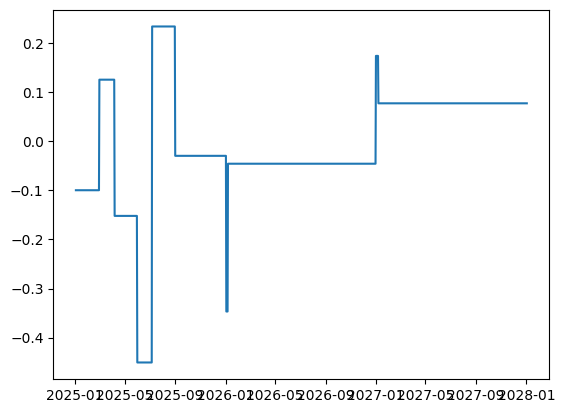

In [240]:
end = '3y'
spx_fwds = eq_curve.curves['SPX'].forwards( end=end, dc=fs.DayCount.Actual360,)
sfr_fwds = eq_curve.curves['SOFR'].forwards( end=end, dc=fs.DayCount.Actual360,)
(100*(spx_fwds - sfr_fwds)).plot()
None